# Inports

In [1]:
import numpy as np
from numpy.random import seed
import pandas as pd

from absl import app
from absl import flags
import os 
from os.path import join
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from utils import *
# from mia.estimators import ShadowModelBundle, AttackModelBundle, prepare_attack_data

2024-06-24 19:43:39.351241: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 19:43:39.376844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 19:43:39.376872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 19:43:39.377559: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-24 19:43:39.381506: I tensorflow/core/platform/cpu_feature_guar

# Functions



In [5]:



class TVTExp : 

    def __init__(self, exp_path) :
        self.exp_path = exp_path
        self.corrupt = self.check_corrupt()
        if not self.corrupt :
            self.args = load_json_field(join(exp_path, 'args.json'))
            

    def check_corrupt(self) :
        if not os.path.exists(join(self.exp_path, 'args.json')) : 
        
            return True 
        files = os.listdir(self.exp_path)
        for file in files : 
        
            if file.endswith('.txt') or file.endswith('.npy') :
                return False
        
        return True

    def get_loss(self) : 
        loss_file = join(self.exp_path, 'loss.npy')
        return np.load(loss_file)

    def get_accuracy(self) :
        accuracy_file = join(self.exp_path, 'accuracy.npy')
        return np.load(accuracy_file) 

    def get_time(self) : 
        with open(join(self.exp_path, 'time.txt'), 'r') as f : 
            return f.read()
    
    def get_results(self) : 
        with open(join(self.exp_path, 'results.txt'), 'r') as f : 
            return f.read()



class Exp : 

    def __init__(self, exp_path) :
        self.exp_path = exp_path
        self.corrupt = self.check_corrupt()
        if not self.corrupt :
            self.args = load_json_field(join(exp_path, 'args.json'))
            self.load_history()
    
    def check_corrupt(self) :
        if not os.path.exists(join(self.exp_path, 'args.json')) : 
            return True 
        files = os.listdir(self.exp_path)
        for file in files : 
            if file.endswith('.txt') or file.endswith('.npy') :
                return False
        return True

    def load_history(self) :
        if self.args['learning_algorithm'] == 'central' : 
            if not os.path.exists(join(self.exp_path, 'centralized.csv')) :
                self.corrupt = True 
                return
            history = pd.read_csv(join(self.exp_path, 'centralized.csv'))
            self.acc = history['val_accuracy']
            self.loss = history['val_loss']
        elif self.args['learning_algorithm'] == 'local' :
            if not os.path.exists(join(self.exp_path, 'client_0.csv')) :
                self.corrupt = True 
                return
            client_files = [f for f in os.listdir(self.exp_path) if (f.startswith('client') and f.endswith('.csv'))]
            histories = [pd.read_csv(join(self.exp_path, f)) for f in client_files]
            self.accs = [h['val_accuracy'] for h in histories]
            self.losses = [h['val_loss'] for h in histories]
            self.acc = np.mean(self.accs, axis=0)
            self.loss = np.mean(self.losses, axis=0)

        elif self.args['learning_algorithm'].startswith('fed') : 
            if not os.path.exists(join(self.exp_path, 'accuracy.npy')) :
                self.corrupt = True 
                return
            
            self.acc = np.load(join(self.exp_path, 'accuracy.npy'))
            self.loss = np.load(join(self.exp_path, 'loss.npy'))

        if not isinstance(self.acc, np.ndarray) : 
            self.acc = np.array(self.acc)
            self.loss = np.array(self.loss)
            
    
    def plot(self, metric='acc', labels=None) :
        
        if labels is not None : 
            mylabels = '_'.join([str(self.args[k]) for k in labels])
        else :
            mylabels = ''
        
        if metric == 'acc' : 
            plt.plot(self.acc, label=mylabels)
        elif metric == 'loss' : 
            plt.plot(self.loss, label=mylabels)
        else : 
            raise ValueError('Invalid metric')

        plt.legend()



class ExpSet : 

    def __init__(self, exps) :
        self.exps = exps
    
    def plot(self, metric='acc', labels=None, filter = None) :
        exps = self.exps
        if filter is not None :
            for k, v in filter.items() : 
                exps = [exp for exp in exps if exp.args[k] == v]
            
        mylabels = ['' ] * len(exps)
        if labels is not None : 
            for i, exp in enumerate(exps) : 
                mylabels[i] = '_'.join([str(exp.args[k]) for k in labels])
        
        ys = []
        for exp in exps :
            if metric == 'acc' : 
                ys.append(exp.acc)
            elif metric == 'loss' : 
                ys.append(exp.loss)
            else : 
                raise ValueError('Invalid metric')
        
        for i, y in enumerate(ys) :
            plt.plot(y, label=mylabels[i])

        plt.legend(prop={'size': 13}, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.2)
        


# Central performance

In [5]:
experiment_id = 'algorithm' + '_' + 'central' + '_'
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if experiment_id in exp_name]
print(experiment_paths)
for exp_path in experiment_paths :
    
    history = pd.read_csv(join(exp_path, 'centralized.csv'))
    central_acc = history['val_accuracy']


    plt.plot(central_acc)

[]


# Local performance

In [ ]:
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH)]
idx_to_remove = [i for i in range(len(experiment_paths)) if not os.path.isdir(experiment_paths[i])]
for i in idx_to_remove :
    experiment_paths.pop(i)

local_dp, local_nondp = [], []
for p in experiment_paths :
    exp = Exp(p) 
    if exp.corrupt :
        continue
    if exp.args['dataset'] == 'cifar10' and exp.args['learning_algorithm'] == 'local' \
        and exp.args['lr'] == 0.001 and exp.args['use_dp'] == True:
        if exp.args['use_dp'] : 
            local_dp.append(exp)
        else :
            local_nondp.append(exp)


# Federated Learning performance

## FedAvg

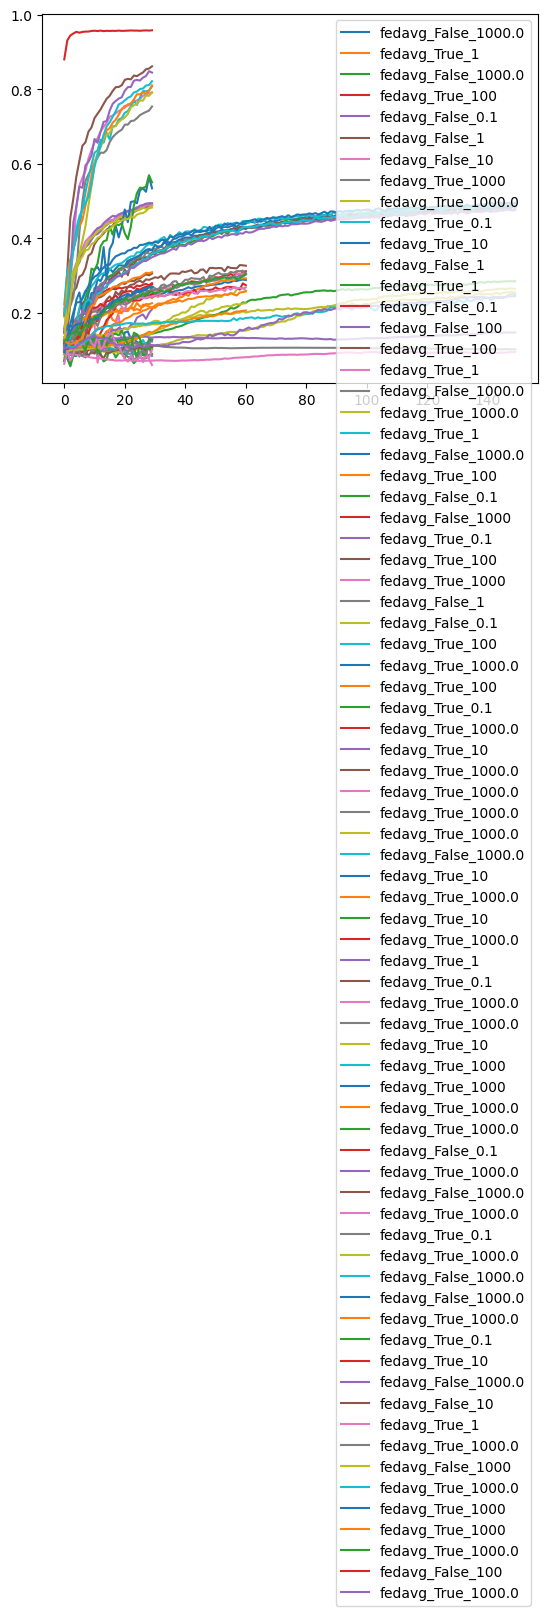

In [6]:

experiment_id = 'fedavg'
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if experiment_id in exp_name]



for p in experiment_paths :
    things = p.split('/')[-1].split('_')
    
    if not os.path.exists(join(p, 'accuracy.npy')): 
        continue 
    
    use_dp =  load_json_field(join(p, 'args.json'), 'use_dp')
    eps = load_json_field(join(p, 'args.json'), 'dp_epsilon')
    alg = load_json_field(join(p, 'args.json'), 'learning_algorithm')
    acc = np.load(join(p, 'accuracy.npy'))
    plt.plot(acc, label=alg + '_' + str(use_dp) + '_' + str(eps))

plt.legend()
plt.show()


In [ ]:
exp_path = "/Users/gadmohamed/Desktop/live repos/FedFort/src/results/cifar10_fedavg_True_04_08_2023_10_10_30"
exp = Exp(exp_path)

## Fedsgd

dp
[0.1, 1, 10, 100, 1000]
adv_cmp
[0.1, 1, 10, 100, 1000]
rdp
[0.1, 1, 10, 100, 1000]
group labels: ['dp', 'adv_cmp', 'rdp']
length of exp_list: 5
length of exp_list: 5
length of exp_list: 5


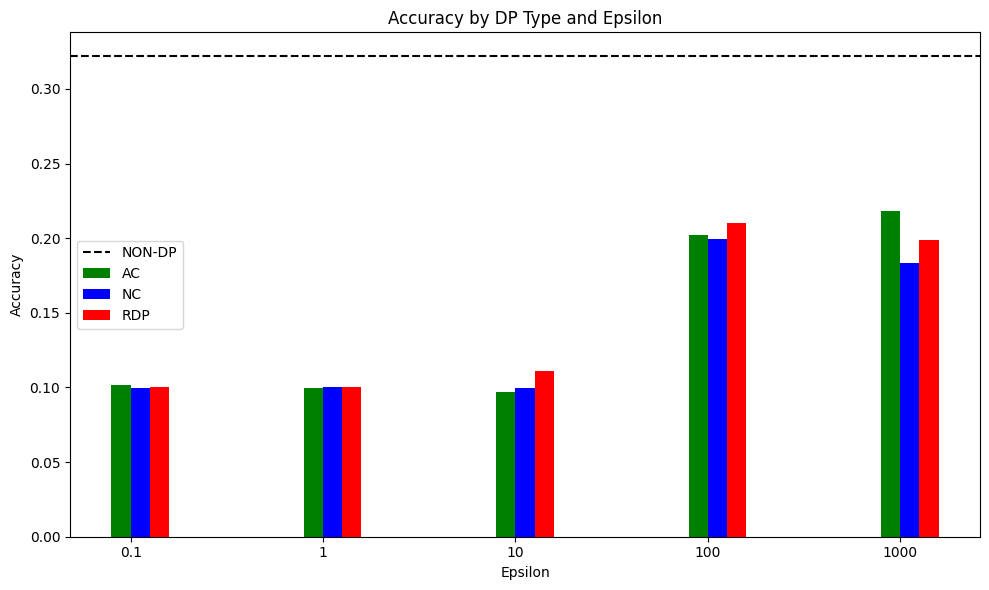

In [38]:
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH)]
idx_to_remove = [i for i in range(len(experiment_paths)) if not os.path.isdir(experiment_paths[i])]
for i in idx_to_remove :
    experiment_paths.pop(i)

# collect all central experiments with/without dp
local_dp, local_nondp = [], []
for p in experiment_paths :
    exp = Exp(p) 
    if exp.corrupt :
        continue
    if exp.args['dataset'] == 'cifar10' and exp.args['learning_algorithm'] == 'fedakd' :
        if exp.args['use_dp'] : 
            local_dp.append(exp)
        else :
            local_nondp.append(exp)

# separate by dp type
dp_types_exps = dict() 
for exp in local_dp :
    if exp.args['dp_type'] not in dp_types_exps : 
        dp_types_exps[exp.args['dp_type']] = []
    dp_types_exps[exp.args['dp_type']].append(exp)

# sort dp_type lists by epsilon
for k, v in dp_types_exps.items() :
    # sort by epsilon
    v.sort(key=lambda x: x.args['dp_epsilon'])
    print(k) 
    print([e.args['dp_epsilon'] for e in v]) 



epsilon_values = sorted(list(set(exp.args['dp_epsilon'] for exp_list in dp_types_exps.values() for exp in exp_list)))
group_labels = list(dp_types_exps.keys())
dp_types_to_labels = {'rdp': 'RDP', 'adv_cmp':'AC', 'dp': 'NC'}
num_epsilon_values = len(epsilon_values)
num_groups = len(dp_types_exps)

bar_width = 0.1
index = np.arange(num_epsilon_values)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['r', 'g', 'b']
colors = {
    'rdp': 'r',
    'adv_cmp': 'g',
    'dp': 'b'
}
print("group labels:", group_labels)
group_labels = ['adv_cmp', 'dp', 'rdp']
for i, dp_type in enumerate(group_labels):
    exp_list = dp_types_exps[dp_type][:5]
    print("length of exp_list:", len(exp_list))
    # exp_list = average_exp_list(exp_list, 'dp_epsilon') 

    acc_values = [exp.acc[-1] for exp in exp_list]
    bar_positions = index + (i - num_groups // 2 + 0.5) * bar_width


    ax.bar(bar_positions, acc_values, width=bar_width, align='center', label=dp_types_to_labels[dp_type], color=colors[dp_type])

# draw horizontal lines
ax.axhline(y=np.mean([list(e.acc)[-1] for e in local_nondp]), color='k', linestyle='--', label='NON-DP')

ax.set_xlabel('Epsilon')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by DP Type and Epsilon')
ax.set_xticks(index)
ax.set_xticklabels(epsilon_values)
ax.legend()

plt.tight_layout()
plt.show()


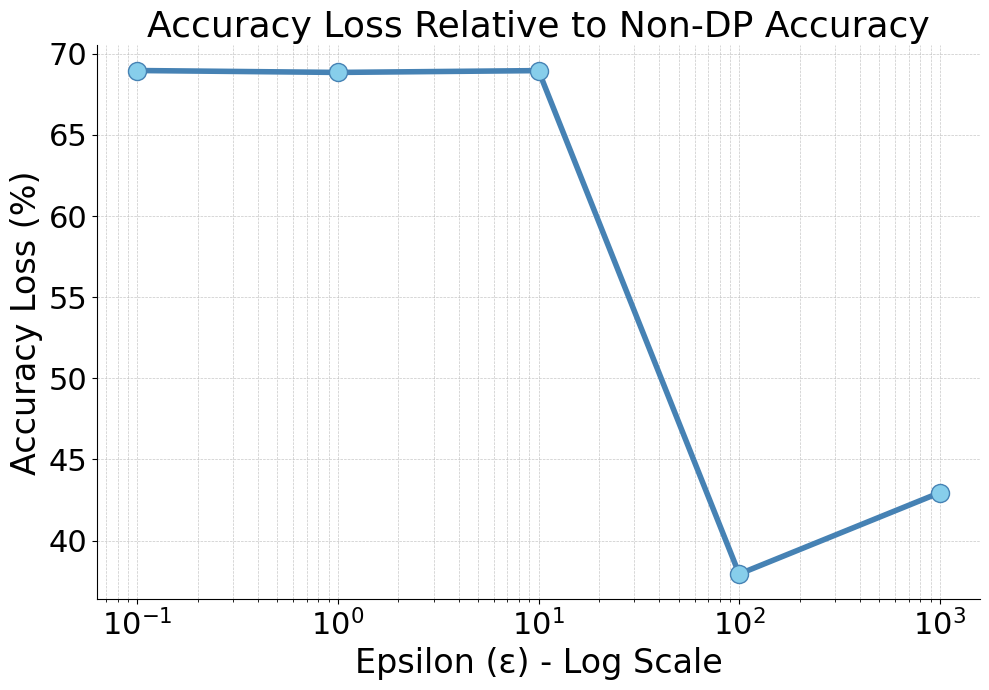

In [39]:
import numpy as np
import matplotlib.pyplot as plt

nondp_acc = np.mean([list(e.acc)[-1] for e in local_nondp])

# Extracting data from dp_types_exps['dp']
epsilon_values = [exp.args['dp_epsilon'] for exp in dp_types_exps['dp']]
acc_values = [exp.acc[-1] for exp in dp_types_exps['dp']]

# Calculate the accuracy loss as a percentage of the non-DP accuracy
accuracy_loss = [(nondp_acc - acc) / nondp_acc * 100 for acc in acc_values]

# Creating the log-log plot for accuracy loss
plt.figure(figsize=(10, 7))
plt.plot(epsilon_values, accuracy_loss, marker='o', linestyle='-', linewidth=4, color='steelblue', markersize=13, markerfacecolor='skyblue', markeredgecolor='steelblue')
plt.xscale('log')
plt.xlabel('Epsilon (ε) - Log Scale', fontsize=24)
plt.ylabel('Accuracy Loss (%)', fontsize=24)
plt.title('Accuracy Loss Relative to Non-DP Accuracy', fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Save the enhanced plot
plt.tight_layout()
plt.savefig('fedakd_dp_accuracy_loss.pdf', dpi=300)
plt.show()


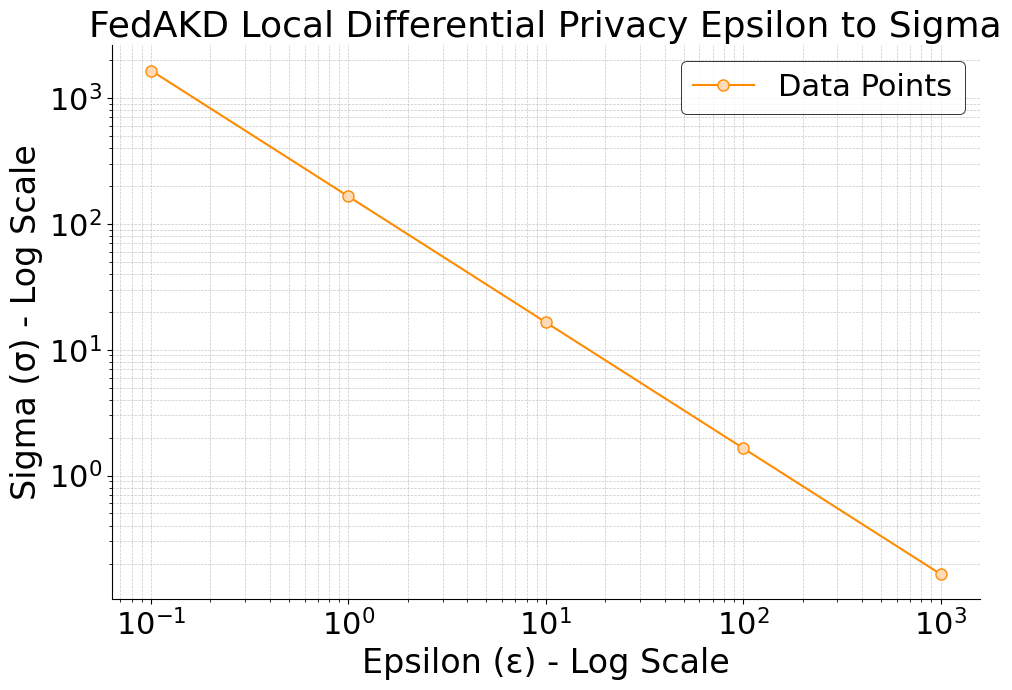

In [43]:
# Assuming the relevant previous code snippets have been run

# Extracting data from dp_types_exps['dp']
epsilon_values = [exp.args['dp_epsilon'] for exp in dp_types_exps['dp']]
sigma_values = [exp.args['sigma'] for exp in dp_types_exps['dp']]

# Creating the log-log plot with connecting lines
plt.figure(figsize=(10, 7))
plt.plot(epsilon_values, sigma_values, label='Data Points', marker='o', linestyle='-', linewidth=1.5, color='darkorange', markersize=8, markerfacecolor='peachpuff', markeredgecolor='darkorange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Epsilon (ε) - Log Scale', fontsize=24)
plt.ylabel('Sigma (σ) - Log Scale', fontsize=24)
plt.title('FedAKD Local Differential Privacy Epsilon to Sigma', fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Legend
legend = plt.legend(loc='best', fontsize=22, frameon=True, edgecolor='black')
legend.get_frame().set_linewidth(0.7)

# Save the polished plot
plt.tight_layout()
plt.savefig('Fedakd_dp_ep_sigma.pdf', dpi=300)
plt.show()


## Local performance

In [13]:
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH)]
idx_to_remove = [i for i in range(len(experiment_paths)) if not os.path.isdir(experiment_paths[i])]
for i in idx_to_remove :
    experiment_paths.pop(i)

local_dp, local_nondp = [], []
for p in experiment_paths :
    exp = TVTExp(p) 
    if exp.corrupt :
        continue
    print(exp.args['dataset'])
    if exp.args['dataset'] == 'cifar10' and exp.args['learning_algorithm'] == 'fedakd' :
        if exp.args['use_dp'] : 
            local_dp.append(exp)
        else :
            local_nondp.append(exp)


dp_types_exps = dict() 
for exp in local_dp :
    if exp.args['dp_type'] not in dp_types_exps : 
        dp_types_exps[exp.args['dp_type']] = []
    dp_types_exps[exp.args['dp_type']].append(exp)
for k, v in dp_types_exps.items() :
    # sort by epsilon
    v.sort(key=lambda x: x.args['dp_epsilon'])
    print(k) 
    print([e.args['dp_epsilon'] for e in v]) 



# epsilon_values = sorted(list(set(exp.args['dp_epsilon'] for exp_list in dp_types_exps.values() for exp in exp_list)))
# group_labels = list(dp_types_exps.keys())
# dp_types_to_labels = {'rdp': 'RDP', 'adv_cmp':'AC', 'dp': 'NC'}
# num_epsilon_values = len(epsilon_values)
# num_groups = len(dp_types_exps)

# bar_width = 0.1
# index = np.arange(num_epsilon_values)

# fig, ax = plt.subplots(figsize=(10, 6))
# colors = ['r', 'g', 'b']
# colors = {
#     'rdp': 'r',
#     'adv_cmp': 'g',
#     'dp': 'b'
# }

# group_labels = ['adv_cmp', 'dp', 'rdp']

# for i, dp_type in enumerate(group_labels):
#     exp_list = dp_types_exps[dp_type]
#     acc_values = [exp.acc[-1] for exp in exp_list]

#     bar_positions = index + (i - num_groups // 2 + 0.5) * bar_width
#     print(bar_positions)
#     ax.bar(bar_positions, acc_values, width=bar_width, align='center', label=dp_types_to_labels[dp_type], color=colors[dp_type])

# # draw horizontal lines
# ax.axhline(y=np.mean([list(e.acc)[-1] for e in local_nondp]), color='k', linestyle='--', label='NON-DP')

# ax.set_xlabel('Epsilon')
# ax.set_ylabel('Accuracy')
# ax.set_title('Accuracy by DP Type and Epsilon')
# ax.set_xticks(index)
# ax.set_xticklabels(epsilon_values)
# ax.legend()

# plt.tight_layout()
# plt.show()


cifar10
cifar10
cifar10
cifar10
cifar10
cifar10
cifar10
mnist
cifar10
cifar10
cifar10
cifar10
cifar10
cifar10
cifar10
mnist
cifar10
cifar10
cifar10
cifar10
mnist
mnist
cifar10
cifar10
cifar10
cifar10
mnist
cifar10
cifar10
mnist
mnist
mnist
cifar10
mnist
mnist
mnist
mnist
mnist
mnist
cifar10
cifar10
cifar10
cifar10
cifar10
cifar10
cifar10
mnist
cifar10
mnist
cifar10
cifar10
cifar10
mnist
mnist
cifar10
mnist
cifar10
mnist
mnist
cifar10
cifar10
cifar10
cifar10
mnist
cifar10
cifar10
cifar10
cifar10
cifar10
mnist
cifar10
mnist
mnist
cifar10
mnist
cifar10
cifar10
cifar10
cifar10
cifar10
mnist
mnist
mnist
cifar10
cifar10
cifar10
cifar10
cifar10
mnist
cifar10
cifar10
cifar10
cifar10
cifar10
cifar10
cifar10
cifar10
cifar10
cifar10
cifar10
cifar10
mnist
mnist
cifar10
cifar10
cifar10
cifar10
cifar10
cifar10
mnist
cifar10
cifar10
cifar10
cifar10
cifar10
cifar10
cifar10
mnist
cifar10
cifar10
dp
[0.1, 1, 10, 100, 1000]
adv_cmp
[0.1, 1, 10, 100, 1000]
rdp
[0.1, 1, 10, 100, 1000]


## Central Performance

dp
[0.1, 1, 10, 100, 1000]
rdp
[0.1, 1, 10, 100, 1000]
adv_cmp
[0.1, 1, 10, 100, 1000]


/Users/gadmohamed/miniforge3/envs/fl/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gadmohamed/miniforge3/envs/fl/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


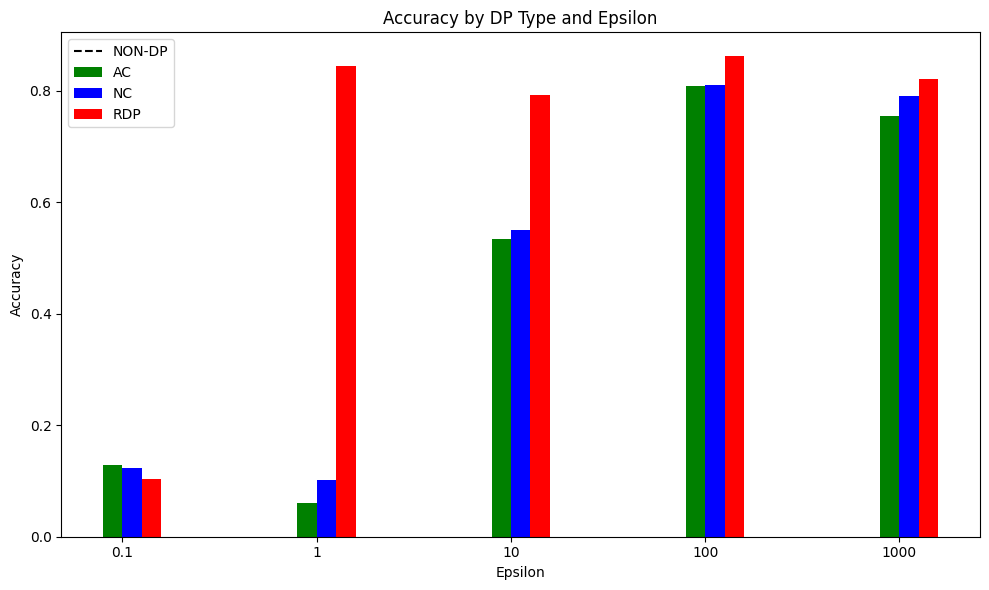

In [27]:
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH)]
idx_to_remove = [i for i in range(len(experiment_paths)) if not os.path.isdir(experiment_paths[i])]
for i in idx_to_remove :
    experiment_paths.pop(i)

# collect all central experiments with/without dp
local_dp, local_nondp = [], []
for p in experiment_paths :
    exp = Exp(p) 
    if exp.corrupt :
        continue
    if exp.args['dataset'] == 'mnist' and exp.args['learning_algorithm'] == 'fedavg' :
        if exp.args['use_dp'] : 
            local_dp.append(exp)
        else :
            local_nondp.append(exp)

# separate by dp type
dp_types_exps = dict() 
for exp in local_dp :
    if exp.args['dp_type'] not in dp_types_exps : 
        dp_types_exps[exp.args['dp_type']] = []
    dp_types_exps[exp.args['dp_type']].append(exp)

# sort dp_type lists by epsilon
for k, v in dp_types_exps.items() :
    # sort by epsilon
    v.sort(key=lambda x: x.args['dp_epsilon'])
    print(k) 
    print([e.args['dp_epsilon'] for e in v]) 



epsilon_values = sorted(list(set(exp.args['dp_epsilon'] for exp_list in dp_types_exps.values() for exp in exp_list)))
group_labels = list(dp_types_exps.keys())
dp_types_to_labels = {'rdp': 'RDP', 'adv_cmp':'AC', 'dp': 'NC'}
num_epsilon_values = len(epsilon_values)
num_groups = len(dp_types_exps)

bar_width = 0.1
index = np.arange(num_epsilon_values)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['r', 'g', 'b']
colors = {
    'rdp': 'r',
    'adv_cmp': 'g',
    'dp': 'b'
}

group_labels = ['adv_cmp', 'dp', 'rdp']
for i, dp_type in enumerate(group_labels):
    exp_list = dp_types_exps[dp_type]
    acc_values = [list(exp.acc)[-1] for exp in exp_list]

    bar_positions = index + (i - num_groups // 2 + 0.5) * bar_width
    # while len(bar_positions) > len(acc_values) :
    #     acc_values.append(0)
    ax.bar(bar_positions, acc_values, width=bar_width, align='center', label=dp_types_to_labels[dp_type], color=colors[dp_type])

# draw horizontal lines
ax.axhline(y=np.mean([list(e.acc)[-1] for e in local_nondp]), color='k', linestyle='--', label='NON-DP')

ax.set_xlabel('Epsilon')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by DP Type and Epsilon')
ax.set_xticks(index)
ax.set_xticklabels(epsilon_values)
ax.legend()

plt.tight_layout()
plt.show()


# DP relaxations noise vs epsilon

### 1

In [4]:
n = 60_000 
bs = 200
e = 20 
delta = 1e-5
dp_types = ['dp', 'adv_cmp', 'rdp'] 

epsilons_range = np.arange(1, 1000, 5)

noise_multipliers = np.zeros((len(dp_types), len(epsilons_range)))
for dp_i, dp_type in enumerate(dp_types) : 
    for eps_i, eps in enumerate(epsilons_range) : 
        ac = DPAccountant(
            data_size= n,
            batch_size= bs, 
            epochs = e,
            target_delta = delta, 
            dp_type = dp_type
        )
        sigma = ac.get_noise_multiplier(target_epsilon=eps)
        noise_multipliers[dp_i, eps_i] = sigma

for dp_i, dp_type in enumerate(dp_types) : 
    plt.plot(epsilons_range[:20], noise_multipliers[dp_i, :20], label=dp_type)
plt.legend()


DP-SGD with sampling rate = 0.333% and noise_multiplier = 20 iterated over 6000 steps satisfies differential privacy with eps = 0.0409 and delta = 1e-05.
The optimal RDP order is 256.0.
DP-SGD with sampling rate = 0.333% and noise_multiplier = 10.0 iterated over 6000 steps satisfies differential privacy with eps = 0.0877 and delta = 1e-05.
The optimal RDP order is 128.0.
DP-SGD with sampling rate = 0.333% and noise_multiplier = 5.0 iterated over 6000 steps satisfies differential privacy with eps = 0.189 and delta = 1e-05.
The optimal RDP order is 63.0.
DP-SGD with sampling rate = 0.333% and noise_multiplier = 2.5 iterated over 6000 steps satisfies differential privacy with eps = 0.411 and delta = 1e-05.
The optimal RDP order is 37.0.
DP-SGD with sampling rate = 0.333% and noise_multiplier = 1.25 iterated over 6000 steps satisfies differential privacy with eps = 1.03 and delta = 1e-05.
The optimal RDP order is 16.0.
DP-SGD with sampling rate = 0.333% and noise_multiplier = 1.875 iterate

KeyboardInterrupt: 

### 2

ValueError: not enough values to unpack (expected 2, got 0)

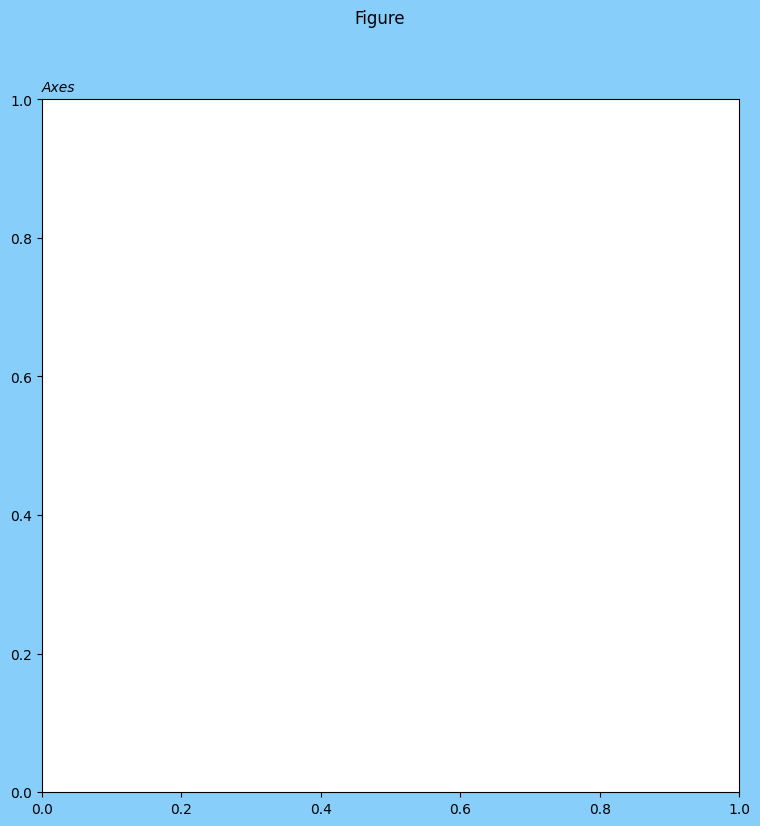

In [5]:
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH)]
idx_to_remove = [i for i in range(len(experiment_paths)) if not os.path.isdir(experiment_paths[i])]
for i in idx_to_remove :
    experiment_paths.pop(i)

fav_exps = []
for p in experiment_paths :
    exp = Exp(p) 
    if exp.corrupt :
        continue
    if exp.args['dataset'] == 'cifar10' and exp.args['learning_algorithm'] == 'local' and exp.args['lr'] == 0.001 and exp.args['use_dp'] == True :
        fav_exps.append(exp)

dp_types = ["dp", "adv_cmp", "rdp"]
labels = ['NC', 'AC', 'RDP']
markers = ['o', 'x', 's']

fig, ax = plt.subplots(figsize=(9, 9), facecolor='lightskyblue')
fig.suptitle('Figure')

ax.set_title('Axes', loc='left', fontstyle='oblique', fontsize='medium')

for i, dp_type in enumerate(dp_types):
    expss = [exp for exp in fav_exps if exp.args['dp_type'] == dp_type]
    xs, ys = [exp.args['dp_epsilon'] for exp in expss], [exp.args['sigma'] for exp in expss]
    xs, ys = zip(*sorted(zip(xs, ys), key=lambda x: x[0]))

    ax.plot(xs, ys, marker=markers[i], label=labels[i])

ax.set_xlabel('DP Epsilon')
ax.set_ylabel('Sigma')

ax.legend()

# Set the x-axis tick labels to the values in xs
ax.set_xticks(xs)

# Set the x-axis to log scale
ax.set_xscale('log')

plt.tight_layout()
plt.show()

## MIA results

In [ ]:
id = 12
exp_id = 'exp_{}'.format(id)
EXP_PATH = join(DATA_PATH, exp_id)
attack_results_file = join(EXP_PATH, 'attack_results', 'attack_results.npy')
attack_results = np.load(attack_results_file, allow_pickle= True).item()  

fpr, tpr, thresholds = attack_results['fpr'], attack_results['tpr'], attack_results['thresholds']
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("fpr:", fpr)
print("tpr:", tpr)
print("thresholds:", thresholds)

# TVT update

In [44]:
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if 'tvt+cifar10' in exp_name]

sample_exp = TVTExp(experiment_paths[0])

args = argparse.Namespace(**sample_exp.args)
new_args = update_args_with_dict(args, {'use_dp' : 'sister'})


accuracy.npy
<class 'dict'>
sister
sister


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/home/lab7/Desktop/FedFort/src/results/tvt+++cifar10_fedavg_True_24_06_2024_19_25_29
/home/lab7/Desktop/FedFort/src/results/tvt+++cifar10_fedakd_True_24_06_2024_17_45_55
/home/lab7/Desktop/FedFort/src/results/tvt+++cifar10_fedavg_True_24_06_2024_13_28_35
/home/lab7/Desktop/FedFort/src/results/tvt+++cifar10_fedakd_True_24_06_2024_13_54_21
/home/lab7/Desktop/FedFort/src/results/tvt+++cifar10_fedakd_True_24_06_2024_11_49_30
/home/lab7/Desktop/FedFort/src/results/tvt+++cifar10_fedavg_True_24_06_2024_15_33_40
/home/lab7/Desktop/FedFort/src/results/tvt+++cifar10_fedavg_True_24_06_2024_11_23_45
4
0
dp
[0.1, 1, 10, 100]


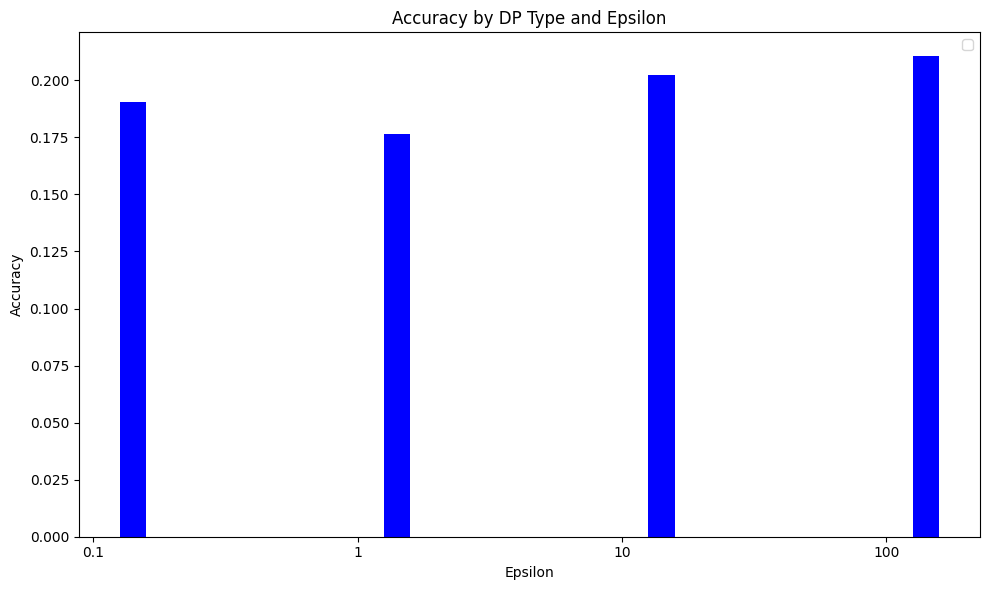

In [8]:
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) ]

idx_to_remove = [i for i in range(len(experiment_paths)) if not os.path.isdir(experiment_paths[i])]
for i in idx_to_remove :
    experiment_paths.pop(i)

# collect all central experiments with/without dp
local_dp, local_nondp = [], []
for p in experiment_paths :
    exp = TVTExp(p) 
    
    if exp.corrupt or 'tvt+++' not in exp.exp_path :
        continue
    print(exp.exp_path) 
    if exp.args['dataset'] == 'cifar10' and exp.args['learning_algorithm'] == 'fedavg' :
        if exp.args['use_dp'] : 
            local_dp.append(exp)
        else :
            local_nondp.append(exp)
    
print(len(local_dp))
print(len(local_nondp))

# separate by dp type
dp_types_exps = dict() 
for exp in local_dp :
    if exp.args['dp_type'] not in dp_types_exps : 
        dp_types_exps[exp.args['dp_type']] = []
    dp_types_exps[exp.args['dp_type']].append(exp)

# sort dp_type lists by epsilon
for k, v in dp_types_exps.items() :
    # sort by epsilon
    v.sort(key=lambda x: x.args['dp_epsilon'])
    print(k) 
    print([e.args['dp_epsilon'] for e in v]) 



epsilon_values = sorted(list(set(exp.args['dp_epsilon'] for exp_list in dp_types_exps.values() for exp in exp_list)))
group_labels = list(dp_types_exps.keys())
dp_types_to_labels = {'rdp': 'RDP', 'adv_cmp':'AC', 'dp': 'NC'}
num_epsilon_values = len(epsilon_values)
num_groups = len(dp_types_exps)


bar_width = 0.1
index = np.arange(num_epsilon_values)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['r', 'g', 'b']
colors = {
    'rdp': 'r',
    'adv_cmp': 'g',
    'dp': 'b'
}

group_labels = ['adv_cmp', 'dp', 'rdp']
for i, dp_type in enumerate(group_labels):
    if dp_type not in dp_types_exps : 
        continue
    exp_list = dp_types_exps[dp_type]
    acc_values = [exp.get_accuracy()[0] for exp in exp_list]

    bar_positions = index + (i - num_groups // 2 + 0.5) * bar_width
    # while len(bar_positions) > len(acc_values) :
    #     acc_values.append(0)
    ax.bar(bar_positions, acc_values, width=bar_width, align='center',  color=colors[dp_type])

# draw horizontal lines
# ax.axhline(y=np.mean([e.get_accuracy() for e in local_nondp]), color='k', linestyle='--', label='NON-DP')

ax.set_xlabel('Epsilon')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by DP Type and Epsilon')
ax.set_xticks(index)
ax.set_xticklabels(epsilon_values)
ax.legend()

plt.tight_layout()
plt.show()
